In [1]:
import physipy
from physipy import Dimension
from fractions import Fraction
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import scipy.integrate as integrate
import scipy.constants as csts
from physipy import s, m, sr, K, units, constants
from physipy import quad
import physipy
import matplotlib.pyplot as plt

# Calculus : numerical toolbox

Some usefull numerical functions are provided, which basicaly consists in dimension-wrapped functions.
The wrapping operation is needed because no mean to hook the handling of Quantity object is avalaible (as it is for numpy's functions and ufuncs).

## Integrate with quad

Lets integrate planck's law : [we know the expected result is $\sigma T^4/\pi$](https://en.wikipedia.org/wiki/Stefan%E2%80%93Boltzmann_law):

In [2]:
# physical constants
hp = constants["h"]
c = constants["c"]
kB = constants["k"]
sigma = constants["Stefan_Boltzmann"]

nm = units["nm"]
mum = units["mum"]

In [3]:
# blackbody at temperature 300K
Tbb = 300*K

# note : computing this factor once saves from overflow problems
x = hp*c / (kB * Tbb)
x_ = csts.h * csts.c /(csts.k * 300)

# Planck's law
def planck(lmbda):
    return 2*hp*c**2/lmbda**5 * 1/(np.exp(x/lmbda)-1) /sr

def planck_(lmbda):
    return 2 * csts.h * csts.c / lmbda**5 * 1 / (np.exp(x_/lmbda)-1)

# expected value
expected = sigma * Tbb**4 / (np.pi*sr)

In [4]:
lmbda_start = 0.001*nm
lmbda_stop = 1000*mum

res, _ = quad(planck, lmbda_start, lmbda_stop)

In [5]:
print(res)
print(expected)
print("error : ", res/expected-1)

146.19902209171852 kg/(s**3*sr)
146.19983511044083 kg/(s**3*sr)
error :  -5.561009844501363e-06


The convergence can be seen : 

In [6]:
integrands = []
ech_stop = np.logspace(2, 4, 20)*mum
ech_stop.favunit = mum
for lmbda_stop in ech_stop:
    res, _ = quad(planck, lmbda_start, lmbda_stop)
    integrands.append(res)

In [7]:
integrands = physipy.quantity.utils.asqarray(integrands)

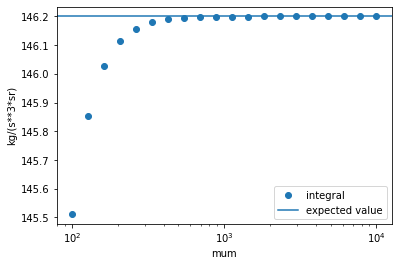

In [8]:
from physipy import setup_matplotlib
setup_matplotlib()

plt.semilogx(ech_stop, integrands, "o", label="integral")
plt.axhline(expected, label="expected value")
plt.legend()

The processing time is quite longer with Quantities. Use this wrapper when speed is not mandatory.

In [9]:
%timeit quad(planck_, lmbda_start.value, lmbda_stop.value)
%timeit quad(planck, lmbda_start, lmbda_stop)

21.8 ms ± 8.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
69.6 ms ± 7.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Other writing possible:

In [10]:
def planck(lmbda, T):
    x = hp*c / (kB * T)
    return 2*hp*c**2/lmbda**5 * 1/(np.exp(x/lmbda)-1) /sr

res, _ = quad(lambda lmbda: planck(lmbda, 300*K), lmbda_start, lmbda_stop)
print(res)

146.19983428886755 kg/(s**3*sr)


Other writing possible : 

In [11]:
res, _ = quad(planck, lmbda_start, lmbda_stop, args=(300*K,))
print(res)

146.19983428886755 kg/(s**3*sr)


## Root solver

A wrapper of `scipy.optimize.root`:

In [12]:
from physipy.optimize import root

def toto(t):
    return -10*s + t

print(root(toto, 0*s))

10.0 s


In [13]:
def tata(t, p):
    return -10*s*p + t

print(root(tata, 0*s, args=(0.5,)))

5.0 s


A wrapper of `scipy.optimize.brentq`:

In [15]:
from physipy.optimize import brentq

In [16]:
print(brentq(toto, -10*s, 10*s))
print(brentq(tata, -10*s, 10*s, args=(0.5,)))

10.0 s
5.0 s
